# House Price Prediction

### Importing required packages and setting required options

In [1]:
import pandas as pd
import math as m
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn import linear_model
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import  explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import  mean_squared_log_error, median_absolute_error

from collections import defaultdict

import pickle

pd.set_option("display.max_columns", 2000)
all_error_metrics_dict_={} # Contains Error Metrics of Train and Test sets for all models used
all_imputed_vals_dict = {} #Contains all imputed values data

### User Defined Functions

#### Function which prints the list of all metrics  used in a regression model and returns a dictionary
    MSE
    RMSE
    Explained Variance
    R2
    MAE
    MSLE
    Median AE

In [2]:
def get_regression_metrics(actualVal, predVal):
    mse = mean_squared_error(actualVal, predVal)
    print("Mean squared error: %.2f"
      % mse )
    
    rmse = np.sqrt(mean_squared_error(actualVal, predVal))
    print("Root Mean squared error: %.2f"
      % rmse )

    var_score = explained_variance_score(actualVal, predVal)
    print("Explained Variance: %.2f"
      % var_score )

    r2 = r2_score(actualVal, predVal)
    print("R2 Score: %.2f"
      % r2 )
    
    mae = mean_absolute_error(actualVal, predVal)
    print("Mean Absolute error: %.2f"
      % mae )

    msle = mean_squared_log_error(actualVal, predVal)
    print("Mean Squared Log error: %.2f"
      % msle )

    med_ae = median_absolute_error(actualVal, predVal)
    print("Median Absolute error: %.2f"
      % med_ae )
    
    error_metrics = {"MSE" : mse,
                    "RMSE" : rmse,
                    "Variance_Score" : var_score, 
                    "R2" : r2, 
                    "Mean_Abs_Err" : mae,
                    "Mean_Sqr_Log_Err" : msle,
                    "Median_Abs_Err" : med_ae
                    }
    return error_metrics

#### Function to train test split the data and provide info about the splits

In [3]:
def fn_train_test_split(input_df):
    X = input_df
    y = np.log(input_df["SalePrice"])
#     y = input_df["SalePrice"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 120)
    print(" X Shape : ",X.shape)
    print(" X Train Shape : ",X_train.shape)
    print(" X Test Shape : ",X_test.shape)
    print(" Y Shape : ",y.shape)
    print(" Y Train Shape : ",y_train.shape)
    print(" Y Test Shape : ",y_test.shape)
    return X_train,X_test,y_train,y_test

#### Function which returns a dataframe of error info - 
    ActualValue,ActualLogValue,PredictedLogValue,,PredcitedValue,ExpActualgLog,Error and Error Percentage
This function expects 3 parameters  - ActualValue,ActualLogValue and PredictedLogValue

In [4]:
def get_metric_df(ActualValue,ActualLogValue,PredictedLogValue):
    df = pd.DataFrame({"ActualValue": ActualValue, 
              "ActualLogValue" : ActualLogValue, 
              "PredictedLogValue" : PredictedLogValue , 
              "PredcitedValue": np.exp(PredictedLogValue), 
              "ExpActualgLog" : np.exp(ActualLogValue)})
    df["Error"] = df["ActualValue"] - df["PredcitedValue"] 
    df["Error_per"] = np.abs((df["ActualValue"]-
                              df["PredcitedValue"])*100/(df["ActualValue"]))

    bins = np.linspace(0, 100, 7)
    df["Error_per_cls"] = np.digitize(df["Error_per"], bins)

    return df

In [5]:
def error_metric_plots(error_df):
    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)
    regplot_act_vs_pred = sn.regplot(error_df["ActualValue"], error_df["PredcitedValue"])
    lmplot_act_vs_pred_errp = sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", 
                                        fit_reg=False, data=error_df)
    lmplot_act_vs_pred_errp_ne1 = sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", 
                                        fit_reg=False,  data=error_df.loc[
        error_df["Error_per_cls"]!=1])
    kdeplot_err_dist = sn.kdeplot(error_df["Error"])
    distplot_err_cdf = sn.distplot(error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True))
    error_plts = {"regplot_act_vs_pred" : regplot_act_vs_pred,
                    "lmplot_act_vs_pred_errp" : lmplot_act_vs_pred_errp,
                    "lmplot_act_vs_pred_errp_ne1" : lmplot_act_vs_pred_errp_ne1, 
                    "kdeplot_err_dist" : kdeplot_err_dist, 
                    "distplot_err_cdf" : distplot_err_cdf
                    }
    return error_plts


In [6]:
def set_all_error_metrics(model,train_err,test_err,model_):
    error_metrics_dict_ = {}
    error_metrics_dict_["Model"] = model_
    error_metrics_dict_["Test"] = test_err
    error_metrics_dict_["Train"] = train_err
    all_error_metrics_dict_[model] = error_metrics_dict_

In [7]:
def set_imputed_vals(column_,valType_, value_):
    imputed_vals={}
    imputed_vals[valType_]=value_
    all_imputed_vals_dict[column_] = imputed_vals

## Reading Dataset

In [8]:
house_prices_df = pd.read_csv("Datasets/train.csv", sep=",", header=0)

In [9]:
house_prices_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [10]:
num_rows_house_prices = house_prices_df.shape[0]
num_cols_house_prices = house_prices_df.shape[1]
house_prices_df.shape

(1460, 81)

In [11]:
house_price_desc_df = house_prices_df.describe(include="all")
house_price_desc_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN

In [12]:
house_prices_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Data distrubution of target variable and analyse outliers

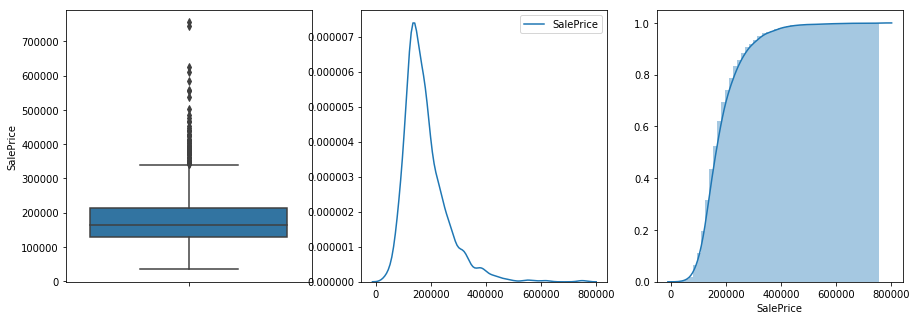

In [13]:
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(15,5)
sn.boxplot(y=house_prices_df["SalePrice"], ax=ax[0])
sn.kdeplot(house_prices_df["SalePrice"], ax=ax[1])
sn.distplot(house_prices_df["SalePrice"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True), ax=ax[2])

In [14]:
print(house_prices_df.shape)
print(house_prices_df.loc[house_prices_df["SalePrice"]>400000].shape)
print(house_prices_df.loc[house_prices_df["SalePrice"]>500000].shape)
print(house_prices_df.loc[house_prices_df["SalePrice"]>600000].shape)
print(house_prices_df.loc[house_prices_df["SalePrice"]>700000].shape)

print(house_prices_df.loc[house_prices_df["SalePrice"]<50000].shape)
print(house_prices_df.loc[house_prices_df["SalePrice"]<60000].shape)
print(house_prices_df.loc[house_prices_df["SalePrice"]<70000].shape)

(1460, 81)
(28, 81)
(9, 81)
(4, 81)
(2, 81)
(5, 81)
(11, 81)
(22, 81)


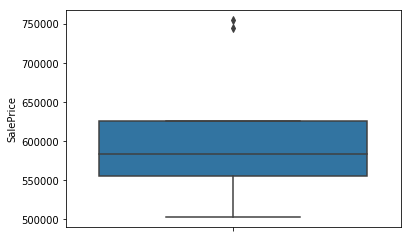

In [15]:
sn.boxplot(y=house_prices_df.loc[house_prices_df["SalePrice"]>500000,"SalePrice"])

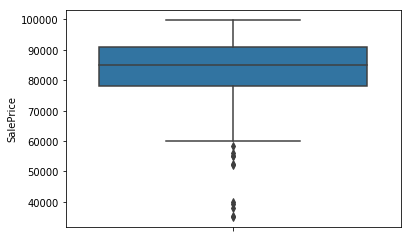

In [16]:
sn.boxplot(y=house_prices_df.loc[house_prices_df["SalePrice"]<100000,"SalePrice"])

In [17]:
house_prices_df.loc[house_prices_df["SalePrice"]<50000,"SalePrice"].shape

(5,)

In [18]:
house_prices_df.shape

(1460, 81)

## Preprocessing

### Handling Missing values

In [19]:
# type(house_prices_df.isna().sum())
missing_values_cnt = pd.DataFrame(house_prices_df.isna().sum(), columns=["count"])
missing_values_cnt["%_missing"] = missing_values_cnt["count"]*100/num_rows_house_prices
missing_values_cnt.loc[missing_values_cnt["count"]>0]

,count,%_missing
LotFrontage,259,17.739726
Alley,1369,93.767123
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
BsmtQual,37,2.534247
BsmtCond,37,2.534247
BsmtExposure,38,2.602740
BsmtFinType1,37,2.534247
BsmtFinType2,38,2.602740
Electrical,1,0.068493


#### Handling misisng values in LotFrontage

In [20]:
mean = house_price_desc_df.loc["mean","LotFrontage"]
set_imputed_vals("LotFrontage","Mean", mean)
house_prices_df["LotFrontage"].fillna(house_price_desc_df.loc["mean","LotFrontage"], inplace=True)

In [21]:
house_price_desc_df = house_prices_df.describe(include="all")
house_price_desc_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1460.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,22.024023,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN

#### Handling misisng values in Alley
Alley (Nominal): Type of alley access to property


In [22]:
set_imputed_vals("Alley","Fill", "No Alley")
house_prices_df["Alley"].fillna("No Alley", inplace=True)

#### Handling misisng values in MasVnrType
None-->None

In [23]:
set_imputed_vals("MasVnrType","Fill", "No MasVnr")
house_prices_df["MasVnrType"].fillna("No MasVnr", inplace=True)

#### Handling misisng values in MasVnrArea

Dependent on MasVnrType

In [24]:
house_prices_df.loc[house_prices_df["MasVnrArea"].isna(),"MasVnrType"].unique()

array(['No MasVnr'], dtype=object)

In [25]:
set_imputed_vals("MasVnrArea","Fill", -1)
house_prices_df["MasVnrArea"].fillna(-1, inplace=True)

#### Handling misisng values in BsmtQual 
NA-->No Basement

In [26]:
set_imputed_vals("BsmtQual","Fill", "No Basement")
house_prices_df["BsmtQual"].fillna("No Basement", inplace=True)

#### Handling misisng values in BsmtCond
NA-->No Basement

In [27]:
set_imputed_vals("BsmtCond","Fill", "No Basement")
house_prices_df["BsmtCond"].fillna("No Basement", inplace=True)

#### Handling misisng values in BsmtExposure
No-->No Exposure

NA-->No Basement


In [28]:
house_prices_df.loc[house_prices_df["BsmtExposure"].isna(),"BsmtQual"].unique()

array(['No Basement', 'Gd'], dtype=object)

In [29]:
house_prices_df.loc[house_prices_df["BsmtExposure"].isna(),"BsmtCond"].unique()

array(['No Basement', 'TA'], dtype=object)

In [30]:
house_prices_df.loc[(house_prices_df["BsmtExposure"].isna()) & (house_prices_df["BsmtCond"]!="No Basement")]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
948,949,60,RL,65.0,14006,Pave,No Alley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0,Unf,0,936,936,GasA,Ex,Y,SBrkr,936,840,0,1776,0,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2002.0,RFn,2,474,TA,TA,Y,144,96,0,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Normal,192500


In [31]:
# Misisng Value in BsmtExposure but not missing in BsmtCond
set_imputed_vals("BsmtExposure","Fill1", "No")
house_prices_df.loc[(house_prices_df["BsmtExposure"].isna()) 
                    & (house_prices_df["BsmtCond"]!="No Basement"),"BsmtExposure"]="No"

# The rest
set_imputed_vals("BsmtExposure","Fill2", "No Basement")
house_prices_df["BsmtExposure"].fillna("No Basement", inplace=True)


#### Handling misisng values in BsmtFinType1

NA-->No Basement

In [32]:
set_imputed_vals("BsmtFinType1","Fill", "No Basement")
house_prices_df["BsmtFinType1"].fillna("No Basement", inplace=True)

#### Handling misisng values in BsmtFinType2

NA-->No Basement

In [33]:
set_imputed_vals("BsmtFinSF2","Fill1", "Low Quality")
set_imputed_vals("BsmtFinSF2","Fill2", "Unfinshed")
set_imputed_vals("BsmtFinSF2","Fill3", "No Basement")
for index_ in house_prices_df.index:
#     print(index_)
    if pd.isnull(house_prices_df.loc[index_,"BsmtFinType2"]):
        if house_prices_df.loc[index_,"BsmtFinSF2"] > house_prices_df.loc[index_,"BsmtUnfSF"]:
            house_prices_df.loc[index_,"BsmtFinType2"] = "Low Quality"
        elif house_prices_df.loc[index_,"BsmtFinSF2"] < house_prices_df.loc[index_,"BsmtUnfSF"]:
            house_prices_df.loc[index_,"BsmtFinType2"] = "Unfinshed"
        else:
            house_prices_df.loc[index_,"BsmtFinType2"] = "No Basement"

#### Handling misisng values in Electrical

In [34]:
house_prices_df[["Id","Electrical"]].groupby("Electrical").count()

,Id
Electrical,
FuseA,94
FuseF,27
FuseP,3
Mix,1
SBrkr,1334


In [35]:
set_imputed_vals("Electrical","Fill", "SBrkr")
house_prices_df["Electrical"].fillna("SBrkr", inplace=True)

#### Handling misisng values in FireplaceQu

In [36]:
# house_prices_df["FireplaceQu"].isna()
house_prices_df.loc[house_prices_df["FireplaceQu"].isna(),"Fireplaces"].unique()

array([0])

In [37]:
set_imputed_vals("FireplaceQu","Fill", "No Fireplace")
house_prices_df.loc[house_prices_df["FireplaceQu"].isna(),"FireplaceQu"] = "No Fireplace"

#### Handling misisng values in GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond

In [38]:
house_prices_df.loc[house_prices_df["GarageType"].isna(),"GarageYrBlt"].unique()

array([nan])

In [39]:
set_imputed_vals("GarageType","Fill", "No Garage")
set_imputed_vals("GarageYrBlt","Fill", 0)
set_imputed_vals("GarageFinish","Fill", "No Garage")
set_imputed_vals("GarageQual","Fill", "No Garage")
set_imputed_vals("GarageCond","Fill", "No Garage")

house_prices_df.loc[house_prices_df["GarageType"].isna(),"GarageType"] = "No Garage"
house_prices_df.loc[house_prices_df["GarageYrBlt"].isna(),"GarageYrBlt"] = 0
house_prices_df.loc[house_prices_df["GarageFinish"].isna(),"GarageFinish"] = "No Garage"
house_prices_df.loc[house_prices_df["GarageQual"].isna(),"GarageQual"] = "No Garage"
house_prices_df.loc[house_prices_df["GarageCond"].isna(),"GarageCond"] = "No Garage"

#### Handling misisng values in PoolQC

In [40]:
set_imputed_vals("PoolQC","Fill", "No Pool")
house_prices_df.loc[house_prices_df["PoolQC"].isna(),"PoolQC"] = "No Pool"

#### Handling misisng values in Fence

In [41]:
set_imputed_vals("Fence","Fill", "No Fence")
house_prices_df.loc[house_prices_df["Fence"].isna(),"Fence"] = "No Fence"

#### Handling misisng values in MiscFeature

In [42]:
set_imputed_vals("MiscFeature","Fill", "No Msc")
house_prices_df.loc[house_prices_df["MiscFeature"].isna(),"MiscFeature"] = "No Msc"

### Validation Post Misisng Value imputation

In [43]:
num_rows_house_prices = house_prices_df.shape[0]
num_cols_house_prices = house_prices_df.shape[1]
house_prices_df.shape

(1460, 81)

In [44]:
house_price_desc_df = house_prices_df.describe(include="all")
house_price_desc_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1460.000000,1460.000000,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1460,1460.000000,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,1460,1460,1460.000000,1460,1460.000000,1460.000000,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,3,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,5,NaN,4,5,6,5,5,5,7,NaN,8,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,6,7,NaN,4,NaN,NaN,6,6,3,NaN,NaN,NaN,NaN,NaN,NaN,4,5,5,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,No Fireplace,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,No Pool,No Fence,No Msc,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,1369,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,954,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,690,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,1453,1179,1406,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.111644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1868.739726,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,22.024023,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,180.734517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,453.697295,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.

In [45]:
# type(house_prices_df.isna().sum())
missing_values_cnt = pd.DataFrame(house_prices_df.isna().sum(), columns=["count"])
missing_values_cnt["%_missing"] = missing_values_cnt["count"]*100/num_rows_house_prices
missing_values_cnt.loc[missing_values_cnt["count"]>0]

,count,%_missing


In [46]:
house_price_cat_v = ['MSSubClass', 'MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood', 'Condition1',
                     'Condition2', 'BldgType','HouseStyle','RoofStyle', 'RoofMatl',
                     'Exterior1st', 'Exterior2nd', 'MasVnrType','Foundation','Heating','CentralAir',
                    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd',
                     'Fireplaces' ,'GarageType'  ,'GarageCars','MiscFeature','MoSold'
                    ]
house_price_ord_v = ['LotShape','Utilities','LandSlope','OverallQual', 'OverallCond','ExterQual', 'ExterCond','BsmtQual',
                     'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2', 'HeatingQC','Electrical','KitchenQual',
                     'Functional','FireplaceQu','YearBuilt', 'YearRemodAdd','GarageFinish','GarageQual', 'GarageCond', 
                     'GarageYrBlt','PavedDrive','PoolQC', 'Fence'
                    ]
house_price_num_v = ['LotFrontage', 'LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea','GarageArea','WoodDeckSF', 'OpenPorchSF',
                     'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','MiscVal','SalePrice'
                    ]

In [47]:
len(house_price_cat_v)+len(house_price_ord_v)+len(house_price_num_v)

77

### Data Conversion

#### Categorical Data

##### Label Encoding

In [48]:
house_prices_cat_dict = defaultdict(LabelEncoder)
for category_ in house_price_cat_v:
    house_prices_df[category_] = house_prices_df[category_].astype("category")
    house_prices_cat_dict[category_] = LabelEncoder()
    house_prices_df[category_] = house_prices_cat_dict[category_].fit_transform(house_prices_df[category_])

##### One hot Encoding

In [49]:
house_prices_cat_ohe_dict = defaultdict(OneHotEncoder)
house_price_cat_fv = []
for category_ in house_price_cat_v:
    house_prices_cat_ohe_dict[category_] = OneHotEncoder()
    temp = house_prices_cat_ohe_dict[category_].fit_transform(house_prices_df[[category_]])
    columns_=[(category_+"_"+str(j)) for j in house_prices_df[category_].value_counts().index]
    temp_= pd.DataFrame(temp.toarray(),columns=columns_, dtype='object')
    temp=temp_.set_index(house_prices_df.index.values)
    house_prices_df=pd.concat([house_prices_df,temp],axis=1)
    house_price_cat_fv.extend(columns_)
    
# house_price_cat_v = house_price_cat_fv

In [50]:
house_prices_df[house_price_cat_v].head()

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageCars,MiscFeature,MoSold
0,5,3,1,1,3,4,5,2,2,0,5,1,1,12,13,1,2,1,1,1,0,2,1,3,1,6,0,1,2,1,1
1,0,3,1,1,3,2,24,1,2,0,2,1,1,8,8,3,1,1,1,0,1,2,0,3,1,4,1,1,2,1,4
2,5,3,1,1,3,4,5,2,2,0,5,1,1,12,13,1,2,1,1,1,0,2,1,3,1,4,1,1,2,1,8
3,6,3,1,1,3,0,6,2,2,0,5,1,1,13,15,3,0,1,1,1,0,1,0,3,1,5,1,5,3,1,1
4,5,3,1,1,3,2,15,2,2,0,5,1,1,12,13,1,2,1,1,1,0,2,1,4,1,7,1,1,3,1,11


In [51]:
house_prices_df[house_price_cat_fv].head()

,MSSubClass_0,MSSubClass_5,MSSubClass_4,MSSubClass_11,MSSubClass_1,MSSubClass_12,MSSubClass_6,MSSubClass_8,MSSubClass_10,MSSubClass_14,MSSubClass_9,MSSubClass_7,MSSubClass_3,MSSubClass_13,MSSubClass_2,MSZoning_3,MSZoning_4,MSZoning_1,MSZoning_2,MSZoning_0,Street_1,Street_0,Alley_1,Alley_0,Alley_2,LandContour_3,LandContour_0,LandContour_1,LandContour_2,LotConfig_4,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,Neighborhood_12,Neighborhood_5,Neighborhood_17,Neighborhood_7,Neighborhood_21,Neighborhood_8,Neighborhood_16,Neighborhood_19,Neighborhood_14,Neighborhood_20,Neighborhood_3,Neighborhood_6,Neighborhood_11,Neighborhood_15,Neighborhood_23,Neighborhood_9,Neighborhood_4,Neighborhood_18,Neighborhood_22,Neighborhood_0,Neighborhood_10,Neighborhood_2,Neighborhood_24,Neighborhood_13,Neighborhood_1,Condition1_2,Condition1_1,Condition1_0,Condition1_6,Condition1_4,Condition1_5,Condition1_3,Condition1_8,Condition1_7,Condition2_2,Condition2_1,Condition2_7,Condition2_4,Condition2_0,Condition2_6,Condition2_5,Condition2_3,BldgType_0,BldgType_4,BldgType_2,BldgType_3,BldgType_1,HouseStyle_2,HouseStyle_5,HouseStyle_0,HouseStyle_7,HouseStyle_6,HouseStyle_1,HouseStyle_4,HouseStyle_3,RoofStyle_1,RoofStyle_3,RoofStyle_0,RoofStyle_2,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_5,RoofMatl_7,RoofMatl_6,RoofMatl_4,RoofMatl_3,RoofMatl_2,RoofMatl_0,Exterior1st_12,Exterior1st_6,Exterior1st_8,Exterior1st_13,Exterior1st_9,Exterior1st_5,Exterior1st_3,Exterior1st_14,Exterior1st_11,Exterior1st_0,Exterior1st_10,Exterior1st_2,Exterior1st_7,Exterior1st_4,Exterior1st_1,Exterior2nd_13,Exterior2nd_8,Exterior2nd_6,Exterior2nd_14,Exterior2nd_10,Exterior2nd_5,Exterior2nd_15,Exterior2nd_12,Exterior2nd_3,Exterior2nd_0,Exterior2nd_7,Exterior2nd_2,Exterior2nd_11,Exterior2nd_1,Exterior2nd_9,Exterior2nd_4,MasVnrType_3,MasVnrType_1,MasVnrType_4,MasVnrType_0,MasVnrType_2,Foundation_2,Foundation_1,Foundation_0,Foundation_3,Foundation_4,Foundation_5,Heating_1,Heating_2,Heating_3,Heating_5,Heating_4,Heating_0,CentralAir_1,CentralAir_0,BsmtFullBath_0,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,BsmtHalfBath_0,BsmtHalfBath_1,BsmtHalfBath_2,FullBath_2,FullBath_1,FullBath_3,FullBath_0,HalfBath_0,HalfBath_1,HalfBath_2,BedroomAbvGr_3,BedroomAbvGr_2,BedroomAbvGr_4,BedroomAbvGr_1,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_0,BedroomAbvGr_7,KitchenAbvGr_1,KitchenAbvGr_2,KitchenAbvGr_3,KitchenAbvGr_0,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_3,TotRmsAbvGrd_6,TotRmsAbvGrd_2,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,TotRmsAbvGrd_1,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_0,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageType_1,GarageType_5,GarageType_3,GarageType_6,GarageType_2,GarageType_4,GarageType_0,GarageCars_2,GarageCars_1,GarageCars_3,GarageCars_0,GarageCars_4,MiscFeature_1,MiscFeature_3,MiscFeature_2,MiscFeature_0,MiscFeature_4,MoSold_5,MoSold_6,MoSold_4,MoSold_3,MoSold_7,MoSold_2,MoSold_9,MoSold_10,MoSold_8,MoSold_11,MoSold_0,MoSold_1
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,

#### Ordinal Data

In [52]:
house_price_ord_v

['LotShape',
 'Utilities',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'YearBuilt',
 'YearRemodAdd',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'GarageYrBlt',
 'PavedDrive',
 'PoolQC',
 'Fence']

In [53]:
# house_prices_ord_dict = defaultdict(LabelEncoder)
# for category_ in house_price_ord_v:
#     house_prices_df[category_] = house_prices_df[category_].astype("category")
#     house_prices_ord_dict[category_] = LabelEncoder()
#     house_prices_df[category_] = house_prices_ord_dict[category_].fit_transform(house_prices_df[category_])

##### LotShape

Lot Shape (Ordinal): General shape of property

       Reg	Regular
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

In [54]:
house_prices_df["LotShape"] = [4 if lotShape_ == "Reg" 
     else 3 if lotShape_ =="IR1" 
     else 2 if lotShape_ =="IR2" 
     else 1 for lotShape_ in house_prices_df["LotShape"]]

In [55]:
house_prices_df["LotShape"].unique()

array([4, 3, 2, 1])

##### Utilities
Utilities (Ordinal): Type of utilities available

       AllPub	All public Utilities (E,G,W,& S)
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only

In [56]:
house_prices_df["Utilities"] = [4 if Utilities_ == "AllPub" 
     else 3 if Utilities_ =="NoSewr" 
     else 2 if Utilities_ =="NoSeWa" 
     else 1 for Utilities_ in house_prices_df["Utilities"]]

In [57]:
house_prices_df["Utilities"].unique()

array([4, 2])

##### LandSlope
Land Slope (Ordinal): Slope of property

       Gtl	Gentle slope
       Mod	Moderate Slope
       Sev	Severe Slope

In [58]:
house_prices_df["LandSlope"] = [3 if LandSlope_ == "Gtl" 
     else 2 if LandSlope_ =="Mod" 
     else 1 for LandSlope_ in house_prices_df["LandSlope"]]

In [59]:
house_prices_df["LandSlope"].unique()

array([3, 2, 1])

##### OverallQual
Overall Qual (Ordinal): Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor


In [60]:
house_prices_df["OverallQual"].unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

##### OverallCond
Overall Cond (Ordinal): Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

In [61]:
house_prices_df["OverallCond"].unique()

array([5, 8, 6, 7, 4, 2, 3, 9, 1])

##### ExterQual
Exter Qual (Ordinal): Evaluates the quality of the material on the exterior

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor



In [62]:
house_prices_df["ExterQual"] = [5 if ExterQual_ == "Ex" 
     else 4 if ExterQual_ =="Gd" 
     else 3 if ExterQual_ =="TA" 
     else 2 if ExterQual_ =="Fa"  
     else 1 for ExterQual_ in house_prices_df["ExterQual"]]

In [63]:
house_prices_df["ExterQual"].unique()

array([4, 3, 5, 2])

##### ExterCond
Exter Cond (Ordinal): Evaluates the present condition of the material on the exterior

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

In [64]:
house_prices_df["ExterCond"] = [5 if ExterCond_ == "Ex" 
     else 4 if ExterCond_ =="Gd" 
     else 3 if ExterCond_ =="TA" 
     else 2 if ExterCond_ =="Fa"  
     else 1 for ExterCond_ in house_prices_df["ExterCond"]]

In [65]:
house_prices_df["ExterCond"].unique()

array([3, 4, 2, 1, 5])

###### BsmtQual
Bsmt Qual (Ordinal): Evaluates the height of the basement

       Ex	Excellent (100+ inches)
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement



In [66]:
house_prices_df["BsmtQual"] = [5 if BsmtQual_ == "Ex" 
     else 4 if BsmtQual_ =="Gd" 
     else 3 if BsmtQual_ =="TA" 
     else 2 if BsmtQual_ =="Fa"  
     else 1 if BsmtQual_ =="Po"   
     else 0 for BsmtQual_ in house_prices_df["BsmtQual"]]

In [67]:
house_prices_df["BsmtQual"].unique()

array([4, 3, 5, 0, 2])

######  BsmtCond

Bsmt Cond (Ordinal): Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement


In [68]:
house_prices_df["BsmtCond"] = [5 if BsmtCond_ == "Ex" 
     else 4 if BsmtCond_ =="Gd" 
     else 3 if BsmtCond_ =="TA" 
     else 2 if BsmtCond_ =="Fa"  
     else 1 if BsmtCond_ =="Po"   
     else 0 for BsmtCond_ in house_prices_df["BsmtCond"]]

In [69]:
house_prices_df["BsmtCond"].unique()

array([3, 4, 0, 2, 1])

######  BsmtExposure

Bsmt Exposure	(Ordinal): Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement


In [70]:
house_prices_df["BsmtExposure"] = [ 4 if BsmtExposure_ =="Gd" 
     else 3 if BsmtExposure_ =="Av" 
     else 2 if BsmtExposure_ =="Mn"  
     else 1 if BsmtExposure_ =="No" 
     else 0 for BsmtExposure_ in house_prices_df["BsmtExposure"]]

In [71]:
house_prices_df["BsmtExposure"].unique()

array([1, 4, 2, 3, 0])

######  BsmtFinType1

BsmtFin Type 1	(Ordinal): Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement



In [72]:
house_prices_df["BsmtFinType1"] = [ 6 if BsmtFinType1_ == "GLQ" 
     else 5 if BsmtFinType1_ == "ALQ" 
     else 4 if BsmtFinType1_ =="BLQ" 
     else 3 if BsmtFinType1_ =="Rec" 
     else 2 if BsmtFinType1_ =="LwQ"  
     else 1 if BsmtFinType1_ =="Unf"
     else 0 for BsmtFinType1_ in house_prices_df["BsmtFinType1"]]

In [73]:
house_prices_df["BsmtFinType1"].unique()

array([6, 5, 1, 3, 4, 0, 2])

######  BsmtFinType2
BsmtFinType 2	(Ordinal): Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

In [74]:
house_prices_df["BsmtFinType2"] = [ 6 if BsmtFinType2_ == "GLQ" 
     else 5 if BsmtFinType2_ == "ALQ" 
     else 4 if BsmtFinType2_ =="BLQ" 
     else 3 if BsmtFinType2_ =="Rec" 
     else 2 if BsmtFinType2_ =="LwQ"  
     else 1 if BsmtFinType2_ =="Unf"
     else 0 for BsmtFinType2_ in house_prices_df["BsmtFinType2"]]

In [75]:
house_prices_df["BsmtFinType2"].unique()

array([1, 4, 0, 5, 3, 2, 6])

###### HeatingQC
HeatingQC (Ordinal): Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor


In [76]:
house_prices_df["HeatingQC"] = [5 if HeatingQC_ == "Ex" 
     else 4 if HeatingQC_ =="Gd" 
     else 3 if HeatingQC_ =="TA" 
     else 2 if HeatingQC_ =="Fa"  
     else 1 for HeatingQC_ in house_prices_df["HeatingQC"]]

In [77]:
house_prices_df["HeatingQC"].unique()

array([5, 4, 3, 2, 1])

######  Electrical
 Electrical (Ordinal): Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

In [78]:
house_prices_df["Electrical"] = [5 if Electrical_ == "SBrkr" 
     else 4 if Electrical_ =="FuseA" 
     else 3 if Electrical_ =="FuseF" 
     else 2 if Electrical_ =="FuseP"  
     else 1 for Electrical_ in house_prices_df["Electrical"]]

In [79]:
house_prices_df["Electrical"].unique()

array([5, 3, 4, 2, 1])

###### KitchenQual
 KitchenQual (Ordinal): Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

In [80]:
house_prices_df["KitchenQual"] = [5 if KitchenQual_ == "Ex" 
     else 4 if KitchenQual_ =="Gd" 
     else 3 if KitchenQual_ =="TA" 
     else 2 if KitchenQual_ =="Fa"  
     else 1 for KitchenQual_ in house_prices_df["KitchenQual"]]

In [81]:
house_prices_df["KitchenQual"].unique()

array([4, 3, 5, 2])

###### Functional
 Functional (Ordinal): Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
       

In [82]:
house_prices_df["Functional"] = [ 8 if Functional_ == "Typ" 
     else 7 if Functional_ == "Min1" 
     else 6 if Functional_ == "Min2"    
     else 5 if Functional_ == "Mod" 
     else 4 if Functional_ =="Maj1" 
     else 3 if Functional_ =="Maj2" 
     else 2 if Functional_ =="Sev"  
     else 1 for Functional_ in house_prices_df["Functional"]]

In [83]:
house_prices_df["Functional"].unique()

array([8, 7, 4, 6, 5, 3, 2])


###### FireplaceQu
 FireplaceQu (Ordinal): Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

In [84]:
house_prices_df["FireplaceQu"] = [5 if FireplaceQu_ == "Ex" 
     else 4 if FireplaceQu_ =="Gd" 
     else 3 if FireplaceQu_ =="TA" 
     else 2 if FireplaceQu_ =="Fa"  
     else 1 if FireplaceQu_ =="Po"
     else 0 for FireplaceQu_ in house_prices_df["FireplaceQu"]]

In [85]:
house_prices_df["FireplaceQu"].unique()

array([0, 3, 4, 2, 5, 1])

###### GarageFinish
 Garage Finish (Ordinal)	: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished
       Unf	Unfinished
       NA	No Garage

In [86]:
house_prices_df["GarageFinish"] = [3 if GarageFinish_ =="Fin" 
     else 2 if GarageFinish_ =="RFn"  
     else 1 if GarageFinish_ =="Unf"
     else 0 for GarageFinish_ in house_prices_df["GarageFinish"]]

In [87]:
house_prices_df["GarageFinish"].unique()

array([2, 1, 3, 0])

###### GarageQual
 Garage Qual (Ordinal): Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage


In [88]:
house_prices_df["GarageQual"] = [5 if GarageQual_ == "Ex" 
     else 4 if GarageQual_ =="Gd" 
     else 3 if GarageQual_ =="TA" 
     else 2 if GarageQual_ =="Fa"  
     else 1 if GarageQual_ =="Po"
     else 0 for GarageQual_ in house_prices_df["GarageQual"]]

In [89]:
house_prices_df["GarageQual"].unique()

array([3, 2, 4, 0, 5, 1])

###### GarageCond
 Garage Cond (Ordinal): Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage


In [90]:
house_prices_df["GarageCond"] = [5 if GarageCond_ == "Ex" 
     else 4 if GarageCond_ =="Gd" 
     else 3 if GarageCond_ =="TA" 
     else 2 if GarageCond_ =="Fa"  
     else 1 if GarageCond_ =="Po"
     else 0 for GarageCond_ in house_prices_df["GarageCond"]]

In [91]:
house_prices_df["GarageCond"].unique()

array([3, 2, 0, 4, 1, 5])

###### PavedDrive
 Paved Drive (Ordinal): Paved driveway

       Y	Paved
       P	Partial Pavement
       N	Dirt/Gravel
       

In [92]:
house_prices_df["PavedDrive"] = [3 if GarageCond_ =="Y" 
     else 2 if GarageCond_ =="P"  
     else 1 for GarageCond_ in house_prices_df["PavedDrive"]]

In [93]:
house_prices_df["PavedDrive"].unique()

array([3, 1, 2])


###### PoolQC
 Pool QC (Ordinal): Pool quality

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool


In [94]:
house_prices_df["PoolQC"] = [4 if PoolQC_ =="Ex" 
     else 3 if PoolQC_ =="Gd"  
     else 2 if PoolQC_ =="TA"
     else 1 if PoolQC_ =="Fa"
     else 0 for PoolQC_ in house_prices_df["PoolQC"]]

In [95]:
house_prices_df["PoolQC"].unique()

array([0, 4, 1, 3])

###### Fence
Fence (Ordinal): Fence quality

       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
       

In [96]:
house_prices_df["Fence"] = [4 if Fence_ =="GdPrv" 
     else 3 if Fence_ =="MnPrv"  
     else 2 if Fence_ =="GdWo"
     else 1 if Fence_ =="MnWw"
     else 0 for Fence_ in house_prices_df["Fence"]]

In [97]:
house_prices_df["Fence"].unique()

array([0, 3, 2, 4, 1])

In [98]:
for ordinal_ in house_price_ord_v:
    house_prices_df[ordinal_] = house_prices_df[ordinal_].astype("category")
house_prices_df[house_price_ord_v].head()

,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,YearBuilt,YearRemodAdd,GarageFinish,GarageQual,GarageCond,GarageYrBlt,PavedDrive,PoolQC,Fence
0,4,4,3,7,5,4,3,4,3,1,6,1,5,5,4,8,0,2003,2003,2,3,3,2003.0,3,0,0
1,4,4,3,6,8,3,3,4,3,4,5,1,5,5,3,8,3,1976,1976,2,3,3,1976.0,3,0,0
2,3,4,3,7,5,4,3,4,3,2,6,1,5,5,4,8,3,2001,2002,2,3,3,2001.0,3,0,0
3,3,4,3,7,5,3,3,3,4,1,5,1,4,5,4,8,4,1915,1970,1,3,3,1998.0,3,0,0
4,3,4,3,8,5,4,3,4,3,3,6,1,5,5,4,8,3,2000,2000,2,3,3,2000.0,3,0,0


#### Numerical Data

In [99]:
house_price_num_v_c = house_price_num_v.copy()

##### Correlation

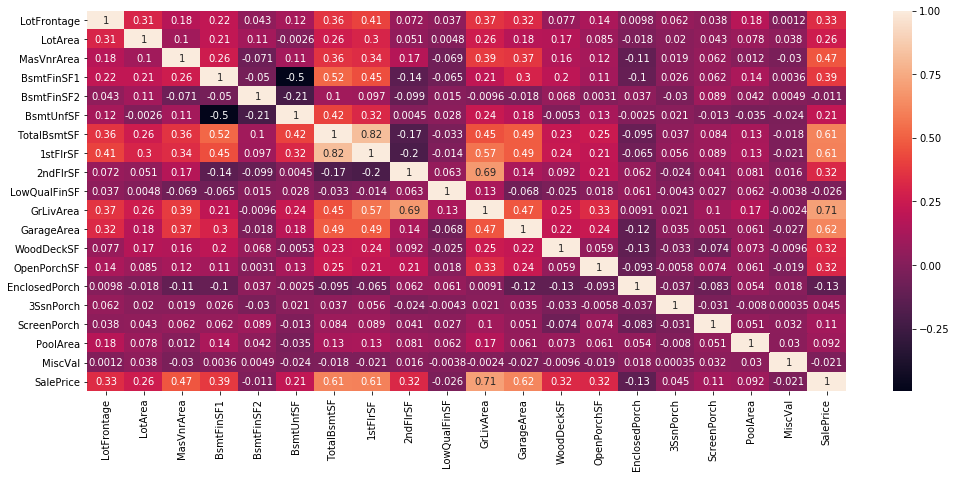

In [100]:
house_price_num_v = house_price_num_v_c.copy()
corr_ = house_prices_df[house_price_num_v].corr()
fig, ax = plt.subplots()
fig.set_size_inches(17,7)
g=sn.heatmap(corr_, annot=True)
plt.setp(g.get_yticklabels(), rotation=0)
plt.show()

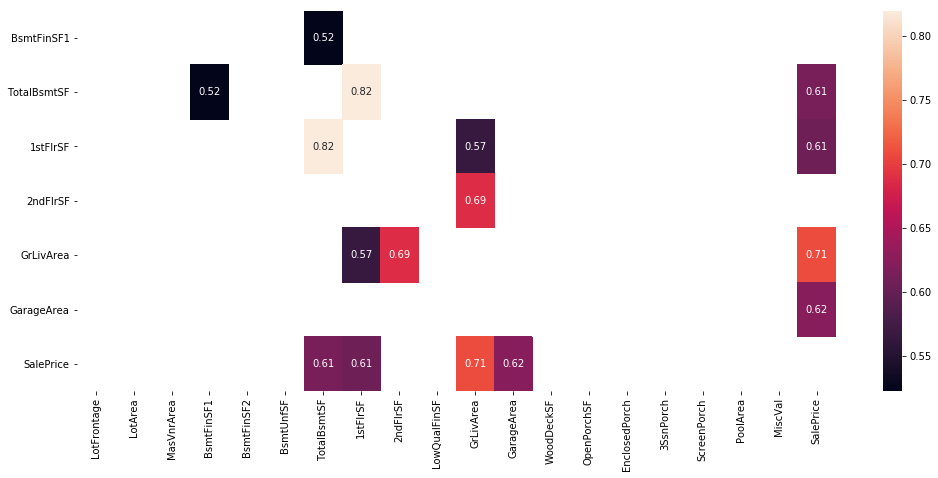

In [101]:
corr_ = house_prices_df[house_price_num_v].corr()
fig, ax = plt.subplots()
fig.set_size_inches(17,7)
g=sn.heatmap(corr_.loc[((np.abs(corr_)>0.5) & (np.abs(corr_)<1)).sum()>0][
    (np.abs(corr_)>0.5) & (np.abs(corr_)<1)] , annot=True)
plt.setp(g.get_yticklabels(), rotation=0)
plt.show()

In [102]:
house_price_num_v.remove("BsmtUnfSF")
house_price_num_v.remove("BsmtFinSF1")
house_price_num_v.remove("1stFlrSF")
house_price_num_v.remove("2ndFlrSF")

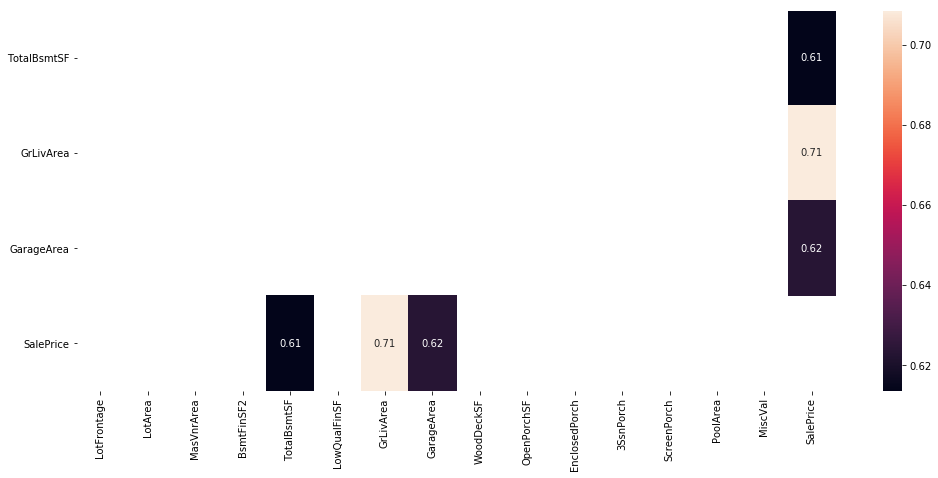

In [103]:
corr_ = house_prices_df[house_price_num_v].corr()
fig, ax = plt.subplots()
fig.set_size_inches(17,7)
g=sn.heatmap(corr_.loc[((np.abs(corr_)>0.5) & (np.abs(corr_)<1)).sum()>0][
    (np.abs(corr_)>0.5) & (np.abs(corr_)<1)] , annot=True)
plt.setp(g.get_yticklabels(), rotation=0)
plt.show()

In [104]:
house_price_desc_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1460.000000,1460.000000,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1460,1460.000000,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,1460,1460,1460.000000,1460,1460.000000,1460.000000,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,3,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,5,NaN,4,5,6,5,5,5,7,NaN,8,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,6,7,NaN,4,NaN,NaN,6,6,3,NaN,NaN,NaN,NaN,NaN,NaN,4,5,5,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,No Fireplace,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,No Pool,No Fence,No Msc,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,1369,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,954,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,690,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,1453,1179,1406,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.111644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1868.739726,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,22.024023,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,180.734517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,453.697295,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.

Normalizing all input variables using Z-Score

In [105]:
house_price_num_zv = []
for column in house_price_num_v:
    house_price_num_zv.append(column+"_zscore")
    house_prices_df[column+"_zscore"] = (house_prices_df[column]-house_price_desc_df.loc["mean",column])/house_price_desc_df.loc["std",column]

In [106]:
house_prices_df[house_price_num_zv].head()

,LotFrontage_zscore,LotArea_zscore,MasVnrArea_zscore,BsmtFinSF2_zscore,TotalBsmtSF_zscore,LowQualFinSF_zscore,GrLivArea_zscore,GarageArea_zscore,WoodDeckSF_zscore,OpenPorchSF_zscore,EnclosedPorch_zscore,3SsnPorch_zscore,ScreenPorch_zscore,PoolArea_zscore,MiscVal_zscore,SalePrice_zscore
0,-0.229293,-0.207071,0.513949,-0.288554,-0.459145,-0.120201,0.370207,0.350880,-0.751918,0.216429,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,0.347154
1,0.451781,-0.091855,-0.570514,-0.288554,0.466305,-0.120201,-0.482347,-0.060710,1.625638,-0.704242,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,0.007286
2,-0.093078,0.073455,0.325828,-0.288554,-0.313261,-0.120201,0.514836,0.631510,-0.751918,-0.070337,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,0.535970
3,-0.456318,-0.096864,-0.570514,-0.288554,-0.687089,-0.120201,0.383528,0.790533,-0.751918,-0.175988,4.091122,-0.116299,-0.270116,-0.068668,-0.087658,-0.515105
4,0.633401,0.375020,1.366028,-0.288554,0.199611,-0.120201,1.298881,1.697903,0.779930,0.563567,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,0.869545


In [107]:
# house_prices_df[house_price_num_v].head()

In [108]:
print("Numerical columns ", len(house_price_num_v))
print("Numerical Z Score columns ", len(house_price_num_zv))
print("\n")
print("Categorical columns ", len(house_price_cat_v))
print("Label Encoded Categorical columns ", len(house_price_cat_fv))
print("\n")
print("Ordinal columns ", len(house_price_ord_v))

Numerical columns  16
Numerical Z Score columns  16


Categorical columns  31
Label Encoded Categorical columns  224


Ordinal columns  26


In [109]:
# house_price_num_zv = house_price_num_v
# house_price_num_zv.extend(house_price_cat_fv)
house_price_num_zv.extend(house_price_cat_v)
house_price_num_zv.extend(house_price_ord_v)

In [110]:
len(house_price_num_zv) 

73

In [111]:
house_price_num_zv.remove("SalePrice_zscore")

In [112]:
house_prices_df[house_price_num_zv].head()

,LotFrontage_zscore,LotArea_zscore,MasVnrArea_zscore,BsmtFinSF2_zscore,TotalBsmtSF_zscore,LowQualFinSF_zscore,GrLivArea_zscore,GarageArea_zscore,WoodDeckSF_zscore,OpenPorchSF_zscore,EnclosedPorch_zscore,3SsnPorch_zscore,ScreenPorch_zscore,PoolArea_zscore,MiscVal_zscore,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageCars,MiscFeature,MoSold,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,YearBuilt,YearRemodAdd,GarageFinish,GarageQual,GarageCond,GarageYrBlt,PavedDrive,PoolQC,Fence
0,-0.229293,-0.207071,0.513949,-0.288554,-0.459145,-0.120201,0.370207,0.350880,-0.751918,0.216429,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,5,3,1,1,3,4,5,2,2,0,5,1,1,12,13,1,2,1,1,1,0,2,1,3,1,6,0,1,2,1,1,4,4,3,7,5,4,3,4,3,1,6,1,5,5,4,8,0,2003,2003,2,3,3,2003.0,3,0,0
1,0.451781,-0.091855,-0.570514,-0.288554,0.466305,-0.120201,-0.482347,-0.060710,1.625638,-0.704242,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,0,3,1,1,3,2,24,1,2,0,2,1,1,8,8,3,1,1,1,0,1,2,0,3,1,4,1,1,2,1,4,4,4,3,6,8,3,3,4,3,4,5,1,5,5,3,8,3,1976,1976,2,3,3,1976.0,3,0,0
2,-0.093078,0.073455,0.325828,-0.288554,-0.313261,-0.120201,0.514836,0.631510,-0.751918,-0.070337,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,5,3,1,1,3,4,5,2,2,0,5,1,1,12,13,1,2,1,1,1,0,2,1,3,1,4,1,1,2,1,8,3,4,3,7,5,4,3,4,3,2,6,1,5,5,4,8,3,2001,2002,2,3,3,2001.0,3,0,0
3,-0.456318,-0.096864,-0.570514,-0.288554,-0.687089,-0.120201,0.383528,0.790533,-0.751918,-0.175988,4.091122,-0.116299,-0.270116,-0.068668,-0.087658,6,3,1,1,3,0,6,2,2,0,5,1,1,13,15,3,0,1,1,1,0,1,0,3,1,5,1,5,3,1,1,3,4,3,7,5,3,3,3,4,1,5,1,4,5,4,8,4,1915,1970,1,3,3,1998.0,3,0,0
4,0.633401,0.375020,1.366028,-0.288554,0.199611,-0.120201,1.298881,1.697903,0.779930,0.563567,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,5,3,1,1,3,2,15,2,2,0,5,1,1,12,13,1,2,1,1,1,0,2,1,4,1,7,1,1,3,1,11,3,4,3,8,5,4,3,4,3,3,6,1,5,5,4,8,3,2000,2000,2,3,3,2000.0,3,0,0


#### Target variable normal distribution

Text(0.5,1,'log (SalePrice)')

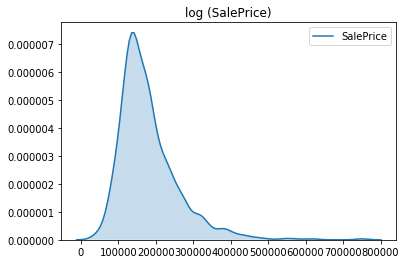

In [113]:
sn.kdeplot(house_prices_df["SalePrice"], shade=True).set_title("log (SalePrice)")

Text(0.5,1,'log (SalePrice)')

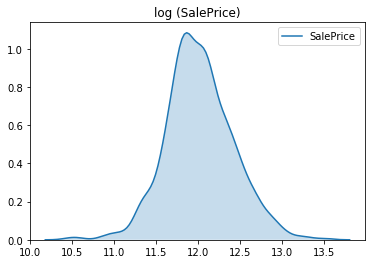

In [114]:
sn.kdeplot(np.log(house_prices_df["SalePrice"]), shade=True).set_title("log (SalePrice)")

As log transforming the target variable converts data into nearly normal distribution, we use log(SalesPrice) in predictive models.

#### Relation of every categorical variable with target variable

In [115]:
len(house_price_cat_v)

31

##  Creating Copy

In [116]:
house_prices_df_master = house_prices_df.copy()

## Test Train Split
Split data for SalePrice < 500000 as values above 500000 are outliers and a very few(9 records) are present

In [117]:
house_prices_df = house_prices_df_master.loc[(house_prices_df_master["SalePrice"]<500000) ].copy()
# house_prices_df = house_prices_df_master.copy()
X_train,X_test,y_train,y_test = fn_train_test_split(house_prices_df)

 X Shape :  (1451, 321)
 X Train Shape :  (1088, 321)
 X Test Shape :  (363, 321)
 Y Shape :  (1451,)
 Y Train Shape :  (1088,)
 Y Test Shape :  (363,)


In [118]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MSSubClass_0,MSSubClass_5,MSSubClass_4,MSSubClass_11,MSSubClass_1,MSSubClass_12,MSSubClass_6,MSSubClass_8,MSSubClass_10,MSSubClass_14,MSSubClass_9,MSSubClass_7,MSSubClass_3,MSSubClass_13,MSSubClass_2,MSZoning_3,MSZoning_4,MSZoning_1,MSZoning_2,MSZoning_0,Street_1,Street_0,Alley_1,Alley_0,Alley_2,LandContour_3,LandContour_0,LandContour_1,LandContour_2,LotConfig_4,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,Neighborhood_12,Neighborhood_5,Neighborhood_17,Neighborhood_7,Neighborhood_21,Neighborhood_8,Neighborhood_16,Neighborhood_19,Neighborhood_14,Neighborhood_20,Neighborhood_3,Neighborhood_6,Neighborhood_11,Neighborhood_15,Neighborhood_23,Neighborhood_9,Neighborhood_4,Neighborhood_18,Neighborhood_22,Neighborhood_0,Neighborhood_10,Neighborhood_2,Neighborhood_24,Neighborhood_13,Neighborhood_1,Condition1_2,Condition1_1,Condition1_0,Condition1_6,Condition1_4,Condition1_5,Condition1_3,Condition1_8,Condition1_7,Condition2_2,Condition2_1,Condition2_7,Condition2_4,Condition2_0,Condition2_6,Condition2_5,Condition2_3,BldgType_0,BldgType_4,BldgType_2,BldgType_3,BldgType_1,HouseStyle_2,HouseStyle_5,HouseStyle_0,HouseStyle_7,HouseStyle_6,HouseStyle_1,HouseStyle_4,HouseStyle_3,RoofStyle_1,RoofStyle_3,RoofStyle_0,RoofStyle_2,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_5,RoofMatl_7,RoofMatl_6,RoofMatl_4,RoofMatl_3,RoofMatl_2,RoofMatl_0,Exterior1st_12,Exterior1st_6,Exterior1st_8,Exterior1st_13,Exterior1st_9,Exterior1st_5,Exterior1st_3,Exterior1st_14,Exterior1st_11,Exterior1st_0,Exterior1st_10,Exterior1st_2,Exterior1st_7,Exterior1st_4,Exterior1st_1,Exterior2nd_13,Exterior2nd_8,Exterior2nd_6,Exterior2nd_14,Exterior2nd_10,Exterior2nd_5,Exterior2nd_15,Exterior2nd_12,Exterior2nd_3,Exterior2nd_0,Exterior2nd_7,Exterior2nd_2,Exterior2nd_11,Exterior2nd_1,Exterior2nd_9,Exterior2nd_4,MasVnrType_3,MasVnrType_1,MasVnrType_4,MasVnrType_0,MasVnrType_2,Foundation_2,Foundation_1,Foundation_0,Foundation_3,Foundation_4,Foundation_5,Heating_1,Heating_2,Heating_3,Heating_5,Heating_4,Heating_0,CentralAir_1,CentralAir_0,BsmtFullBath_0,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,BsmtHalfBath_0,BsmtHalfBath_1,BsmtHalfBath_2,FullBath_2,FullBath_1,FullBath_3,FullBath_0,HalfBath_0,HalfBath_1,HalfBath_2,BedroomAbvGr_3,BedroomAbvGr_2,BedroomAbvGr_4,BedroomAbvGr_1,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_0,BedroomAbvGr_7,KitchenAbvGr_1,KitchenAbvGr_2,KitchenAbvGr_3,KitchenAbvGr_0,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_3,TotRmsAbvGrd_6,TotRmsAbvGrd_2,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,TotRmsAbvGrd_1,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_0,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageType_1,GarageType_5,GarageType_3,GarageType_6,GarageType_2,GarageType_4,GarageType_0,GarageCars_2,GarageCars_1,GarageCars_3,GarageCars_0,GarageCars_4,MiscFeature_1,MiscFeature_3,MiscFeature_2,MiscFeature_0,MiscFeature_4,MoSold_5,MoSold_6,MoSold_4,MoSold_3,MoSold_7,MoSold_2,MoSold_9,MoSold_10,MoSold_8,MoSold_11,MoSold_0,MoSold_1,LotFrontage_zscore,LotArea_zscore,MasVnrArea_zscore,BsmtFinSF2_zscore,TotalBsmtSF_zscore,LowQualFinSF_zscore,GrLivArea_zscore,GarageArea_zscore,WoodDeckSF_zscore,OpenPorchSF_zscore,EnclosedPorch_

## Predictive Modelling

## Model 1

### Linear Regression

In [119]:
regr = linear_model.LinearRegression()
regr.fit(X_train[house_price_num_zv], y_train)
y_train_pred = regr.predict(X_train[house_price_num_zv])
y_pred = regr.predict(X_test[house_price_num_zv])
regr.score(X_train[house_price_num_zv], y_train)

0.8751004461750618

In [120]:
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [-5.85696439e-03  2.09384665e-02  5.34651418e-03  1.26675447e-02
  1.16285087e-02  5.96672284e-03  8.37465976e-02  1.62105525e-02
  1.44537108e-02  3.91668701e-03  1.03733777e-02  6.39200140e-03
  1.61706406e-02  1.78407697e-02  2.67133345e-02 -3.87775850e-03
 -3.46820868e-03  1.80815181e-01  2.50734856e-02  1.57003322e-02
 -3.12665035e-03  1.24619219e-03  5.48270833e-03 -5.91513942e-02
 -1.09735916e-02 -7.05328682e-03  2.19956726e-03  3.84314575e-03
 -6.03113709e-03  6.22288620e-03  2.72575989e-03  2.16801100e-02
  1.29493231e-02  4.18603408e-02  4.93907775e-02  3.47546897e-02
  3.72043497e-02  1.96122306e-02  1.22271205e-02  1.22612558e-02
  9.44831022e-03 -1.51393858e-04 -7.76482225e-03  5.30311051e-02
 -2.74766688e-02  1.06985863e-03  2.40227257e-03  1.34041879e-01
 -2.43282437e-02  6.16956750e-02  3.94555131e-02  2.11089260e-02
 -1.60536345e-02  2.92178558e-02 -5.79803765e-04  1.65211386e-02
  8.92260089e-03 -1.23848281e-02  1.60188299e-02  3.59240963e-03
  1.69531

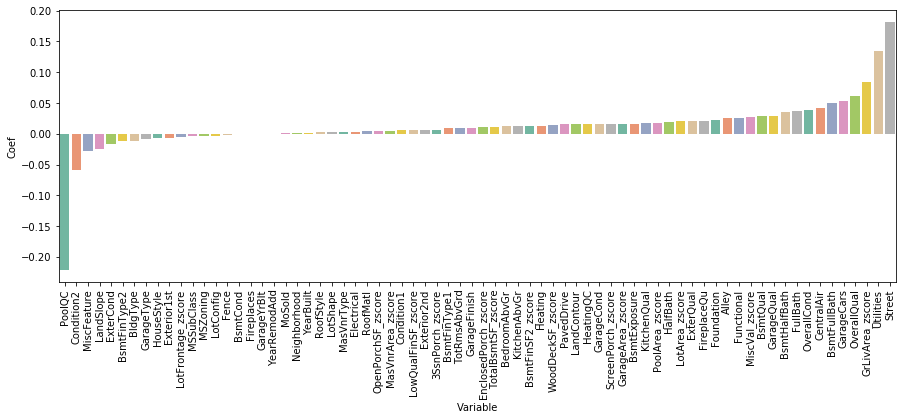

In [121]:
coeff = pd.DataFrame({"Coef":regr.coef_, "Variable":house_price_num_zv})
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
g = sn.barplot(y="Coef", x="Variable", data = coeff.sort_values(by="Coef"), palette="Set2")
plt.setp( g.get_xticklabels(), rotation=90)
plt.show()

In [122]:
metrics_ = get_regression_metrics(y_test,y_pred)

Mean squared error: 0.02
Root Mean squared error: 0.15
Explained Variance: 0.87
R2 Score: 0.87
Mean Absolute error: 0.10
Mean Squared Log error: 0.00
Median Absolute error: 0.07


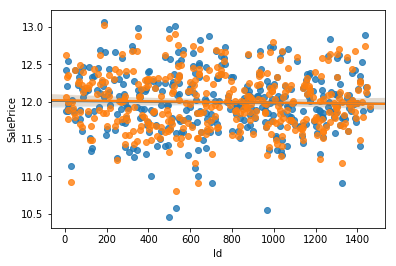

In [123]:
fig, ax = plt.subplots()
sn.regplot(X_test["Id"], y_test)
sn.regplot(X_test["Id"], y_pred)

In [124]:
train_error_df = get_metric_df(X_train["SalePrice"],y_train, y_train_pred)

In [125]:
train_error_df.head()

,ActualLogValue,ActualValue,ExpActualgLog,PredcitedValue,PredictedLogValue,Error,Error_per,Error_per_cls
177,12.058153,172500,172500.0,182471.632874,12.114350,-9971.632874,5.780657,1
311,11.790557,132000,132000.0,137365.294315,11.830399,-5365.294315,4.064617,1
31,11.914048,149350,149350.0,128814.058982,11.766125,20535.941018,13.750212,1
1097,12.043554,170000,170000.0,156303.052651,11.959552,13696.947349,8.057028,1
1420,12.100156,179900,179900.0,175526.107020,12.075543,4373.892980,2.431291,1


In [126]:
test_error_df = get_metric_df(X_test["SalePrice"],y_test,y_pred)

In [127]:
test_error_df.head()

,ActualLogValue,ActualValue,ExpActualgLog,PredcitedValue,PredictedLogValue,Error,Error_per,Error_per_cls
539,12.513557,272000,272000.0,263312.644495,12.481097,8687.355505,3.193881,1
320,12.744444,342643,342643.0,319952.243066,12.675927,22690.756934,6.622274,1
164,11.931636,152000,152000.0,145284.528022,11.886449,6715.471978,4.418074,1
1249,11.686879,119000,119000.0,116297.914932,11.663910,2702.085068,2.270660,1
985,11.736069,125000,125000.0,104767.223279,11.559496,20232.776721,16.186221,1


## Metrics

### Training Dataset

#### Metrics in Train Dataset

In [128]:
train_err_met = get_regression_metrics(train_error_df["ActualValue"], train_error_df["PredcitedValue"])

Mean squared error: 765796697.57
Root Mean squared error: 27673.03
Explained Variance: 0.85
R2 Score: 0.85
Mean Absolute error: 16344.06
Mean Squared Log error: 0.02
Median Absolute error: 11048.32


#### Plot of Actual Value and Predicted Value
Actual Value - Blue
Pred value - Orange

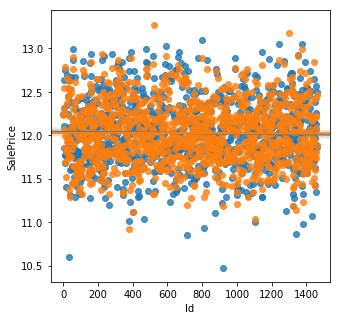

In [129]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sn.regplot(X_train["Id"], y_train)
sn.regplot(X_train["Id"], y_train_pred)

In most of the data points, the orange and blue dots overlap

#### Plot between actual and predicted values.

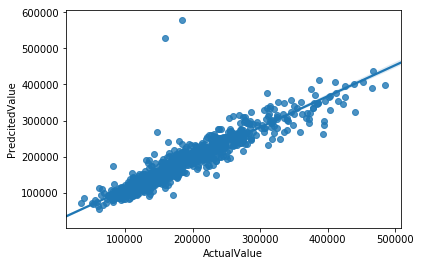

In [130]:
fig, ax = plt.subplots()
sn.regplot(train_error_df["ActualValue"], train_error_df["PredcitedValue"])

Most of the data points in training datset lie around the predictive line, although, few value are predicted too high. 

#### PLot beween Actual and Pred values colored by percentage error. 
 0,  16.66,  33.3,  50, 66.66,  83.33, 100

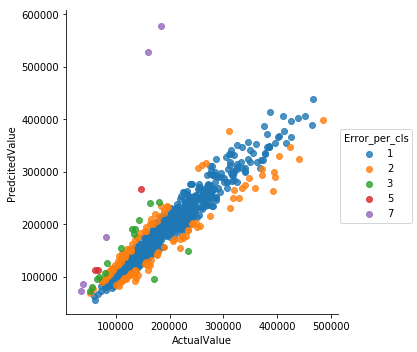

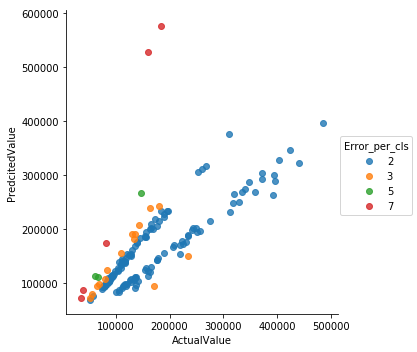

In [131]:
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False, data=train_error_df)
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False,  data=train_error_df.loc[
    train_error_df["Error_per_cls"]!=1])

#### Error Distributions

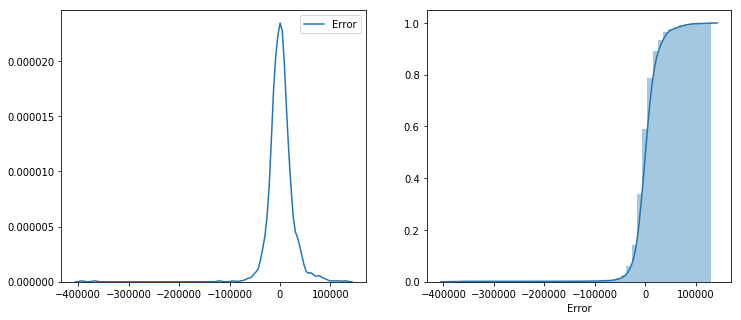

In [132]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.kdeplot(train_error_df["Error"],ax=ax[0])
sn.distplot(train_error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True), ax=ax[1])

Most of the errors are centered at 0

### Test Dataset

Metrics in Test Dataset

In [133]:
test_err_met = get_regression_metrics(test_error_df["ActualValue"], test_error_df["PredcitedValue"])

Mean squared error: 662495042.43
Root Mean squared error: 25738.98
Explained Variance: 0.87
R2 Score: 0.87
Mean Absolute error: 17062.09
Mean Squared Log error: 0.02
Median Absolute error: 11661.89


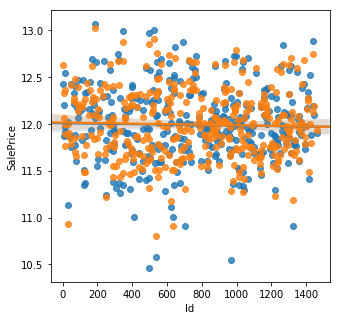

In [134]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sn.regplot(X_test["Id"], y_test)
sn.regplot(X_test["Id"], y_pred)

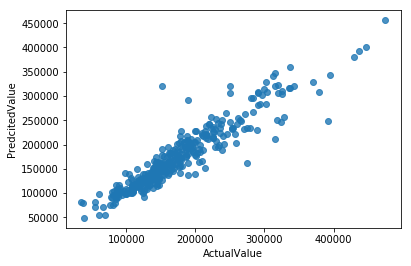

In [135]:
sn.regplot(test_error_df["ActualValue"], test_error_df["PredcitedValue"], fit_reg=False)

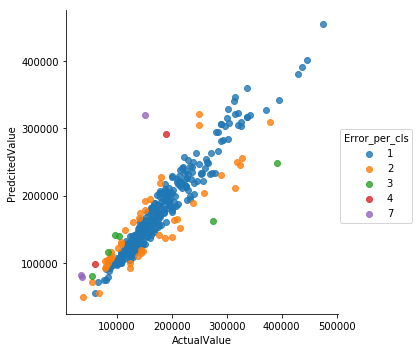

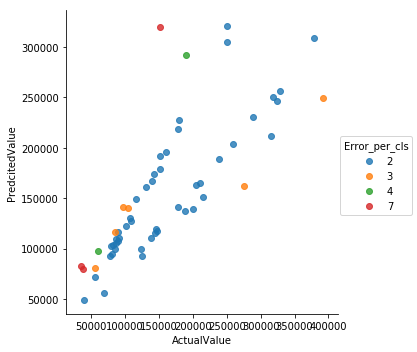

In [136]:
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False, data=test_error_df)
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False,  data=test_error_df.loc[
    test_error_df["Error_per_cls"]!=1])

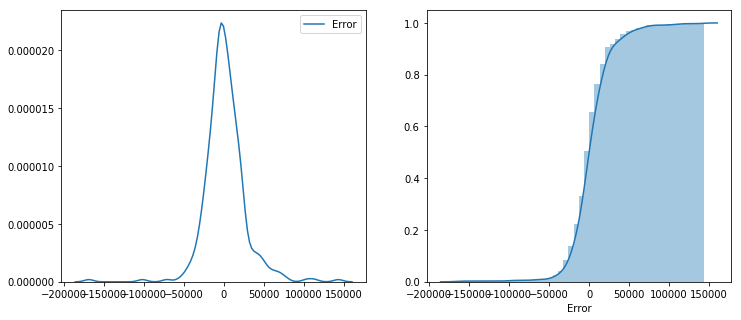

In [137]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.kdeplot(test_error_df["Error"],ax=ax[0])
sn.distplot(test_error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True), ax=ax[1])

In [138]:
set_all_error_metrics("Linear_Regression",train_err_met,test_err_met,regr)

## Model 2

### Lasso Regression

In [187]:
# regr = linear_model.Lasso(alpha=0.00018, normalize=True) - 87 81 90
# regr = linear_model.Lasso(alpha=0.0041) # 88 87 86
# regr = linear_model.Lasso(alpha=0.00088)- 87 84 89
regr = linear_model.Lasso(alpha=0.9)
regr.fit(X_train[house_price_num_zv], y_train)
y_train_pred = regr.predict(X_train[house_price_num_zv])
y_pred = regr.predict(X_test[house_price_num_zv])
regr.score(X_train[house_price_num_zv], y_train)

0.4328196924913999

In [188]:
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.         -0.          0.
 -0.         -0.         -0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
 -0.          0.         -0.          0.          0.          0.
  0.          0.          0.         -0.          0.          0.
 -0.          0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.0040515   0.00448857  0.
  0.          0.          0.00017289  0.          0.         -0.        ]


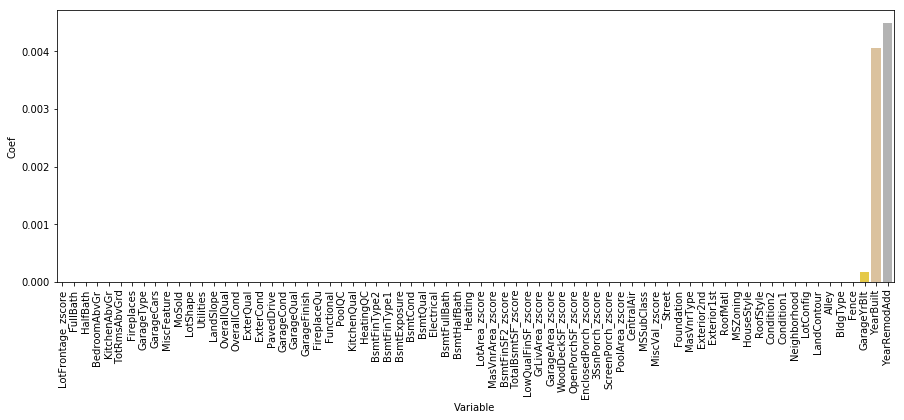

In [189]:
coeff = pd.DataFrame({"Coef":regr.coef_, "Variable":house_price_num_zv})
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
g = sn.barplot(y="Coef", x="Variable", data = coeff.sort_values(by="Coef"), palette="Set2")
plt.setp( g.get_xticklabels(), rotation=90)
plt.show()

In [190]:
metrics = get_regression_metrics(y_test,y_pred)

Mean squared error: 0.08
Root Mean squared error: 0.29
Explained Variance: 0.49
R2 Score: 0.49
Mean Absolute error: 0.22
Mean Squared Log error: 0.00
Median Absolute error: 0.17


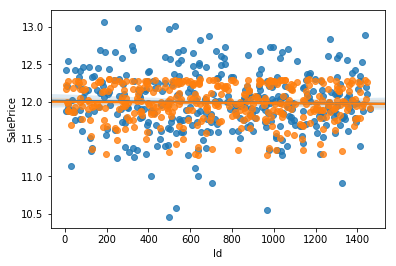

In [191]:
fig, ax = plt.subplots()
sn.regplot(X_test["Id"], y_test)
sn.regplot(X_test["Id"], y_pred)

In [192]:
train_error_df = get_metric_df(X_train["SalePrice"],y_train, y_train_pred)

In [193]:
train_error_df.head()

,ActualLogValue,ActualValue,ExpActualgLog,PredcitedValue,PredictedLogValue,Error,Error_per,Error_per_cls
177,12.058153,172500,172500.0,141088.556242,11.857143,31411.443758,18.209533,2
311,11.790557,132000,132000.0,164784.880226,12.012396,-32784.880226,24.837030,2
31,11.914048,149350,149350.0,181024.820108,12.106389,-31674.820108,21.208450,2
1097,12.043554,170000,170000.0,180102.019069,12.101279,-10102.019069,5.942364,1
1420,12.100156,179900,179900.0,153932.982547,11.944273,25967.017453,14.434140,1


In [194]:
test_error_df = get_metric_df(X_test["SalePrice"],y_test,y_pred)

In [195]:
test_error_df.head()

,ActualLogValue,ActualValue,ExpActualgLog,PredcitedValue,PredictedLogValue,Error,Error_per,Error_per_cls
539,12.513557,272000,272000.0,206135.455648,12.236289,65864.544352,24.214906,2
320,12.744444,342643,342643.0,214349.899646,12.275365,128293.100354,37.442207,3
164,11.931636,152000,152000.0,151514.516284,11.928437,485.483716,0.319397,1
1249,11.686879,119000,119000.0,131589.086943,11.787439,-12589.086943,10.579065,1
985,11.736069,125000,125000.0,131589.086943,11.787439,-6589.086943,5.271270,1


## Metrics

### Training Dataset

#### Metrics in Train Dataset

In [196]:
train_err_met = get_regression_metrics(train_error_df["ActualValue"], train_error_df["PredcitedValue"])

Mean squared error: 3322555493.01
Root Mean squared error: 57641.61
Explained Variance: 0.37
R2 Score: 0.35
Mean Absolute error: 39893.11
Mean Squared Log error: 0.08
Median Absolute error: 27387.10


#### Plot of Actual Value and Predicted Value
Actual Value - Blue
Pred value - Orange

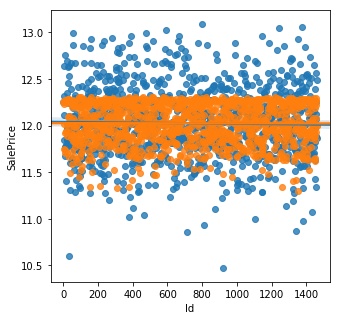

In [197]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sn.regplot(X_train["Id"], y_train)
sn.regplot(X_train["Id"], y_train_pred)

In most of the data points, the orange and blue dots overlap

#### Plot between actual and predicted values.

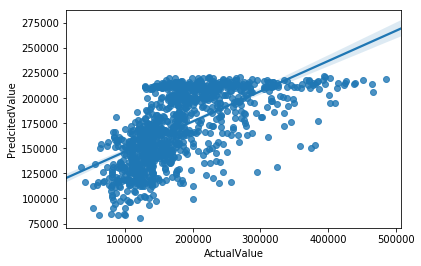

In [198]:
fig, ax = plt.subplots()
sn.regplot(train_error_df["ActualValue"], train_error_df["PredcitedValue"])

Most of the data points in training datset lie around the predictive line, although, few value are predicted too high. 

#### PLot beween Actual and Pred values colored by percentage error. 
 0,  16.66,  33.3,  50, 66.66,  83.33, 100

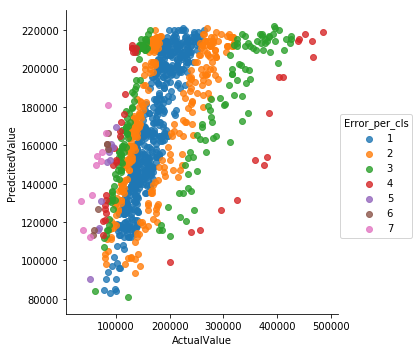

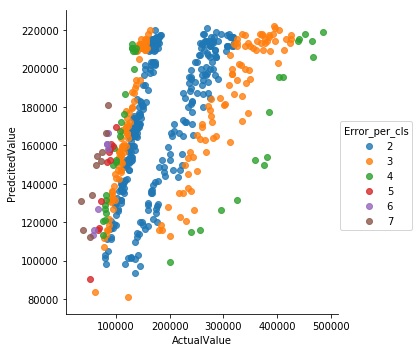

In [199]:
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False, data=train_error_df)
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False,  data=train_error_df.loc[
    train_error_df["Error_per_cls"]!=1])

#### Error Distributions

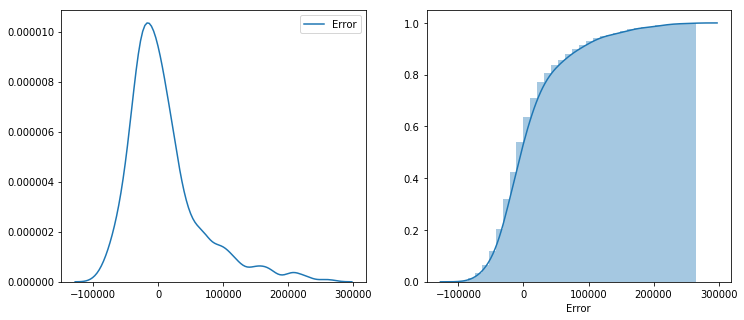

In [200]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.kdeplot(train_error_df["Error"],ax=ax[0])
sn.distplot(train_error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True), ax=ax[1])

Most of the errors are centered at 0

### Test Dataset

Metrics in Test Dataset

In [153]:
test_err_met = get_regression_metrics(test_error_df["ActualValue"], test_error_df["PredcitedValue"])

Mean squared error: 597231557.41
Root Mean squared error: 24438.32
Explained Variance: 0.89
R2 Score: 0.89
Mean Absolute error: 16717.96
Mean Squared Log error: 0.02
Median Absolute error: 11976.80


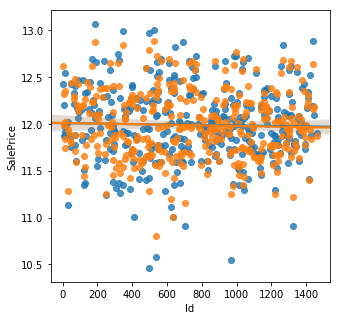

In [154]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sn.regplot(X_test["Id"], y_test)
sn.regplot(X_test["Id"], y_pred)

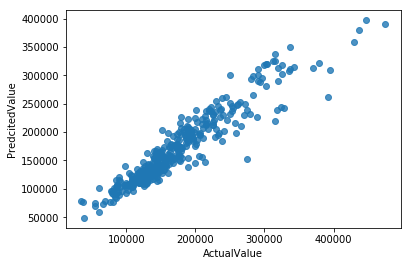

In [155]:
sn.regplot(test_error_df["ActualValue"], test_error_df["PredcitedValue"], fit_reg=False)

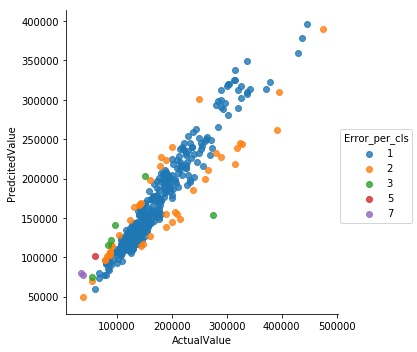

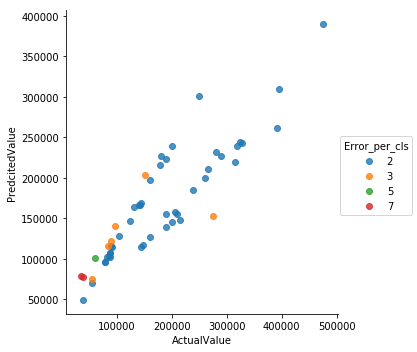

In [156]:
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False, data=test_error_df)
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False,  data=test_error_df.loc[
    test_error_df["Error_per_cls"]!=1])

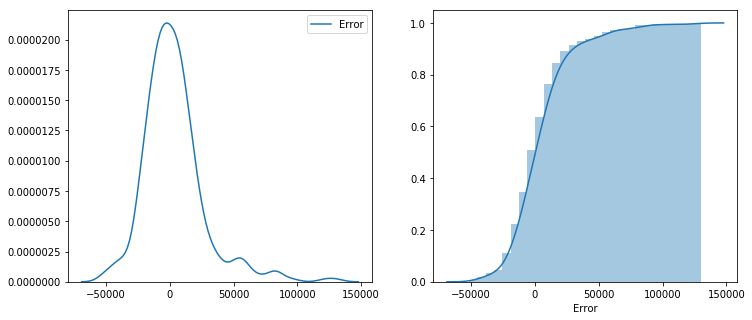

In [157]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.kdeplot(test_error_df["Error"],ax=ax[0])
sn.distplot(test_error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True), ax=ax[1])

In [158]:
set_all_error_metrics("Lasso_Regression",train_err_met,test_err_met,regr)

## Model 3

### Ridge Regression

In [159]:
regr = linear_model.Ridge(alpha=260)
regr.fit(X_train[house_price_num_zv], y_train)
y_train_pred = regr.predict(X_train[house_price_num_zv])
y_pred = regr.predict(X_test[house_price_num_zv])
regr.score(X_train[house_price_num_zv], y_train)

0.8631213013183383

In [160]:
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [-4.24671477e-03  1.83864609e-02  8.15139003e-03  7.72906251e-03
  1.56878002e-02  3.88828226e-03  4.91403153e-02  2.42410542e-02
  1.46682104e-02  7.05589620e-03  6.90629443e-03  4.49189900e-03
  1.43600989e-02 -1.42413097e-02  8.57485243e-04 -1.92361296e-03
 -2.29060689e-03  3.75641119e-03  5.95251643e-03  8.06250004e-03
 -2.91013594e-03  1.72619409e-03  2.74843650e-03 -6.78028392e-03
 -1.29894847e-02 -7.59897330e-03  3.08986176e-03  8.08386877e-03
 -6.17683090e-03  6.12529259e-03  1.09807095e-03  1.30266781e-02
  2.38820329e-03  7.34792579e-03  1.73209670e-02  1.35201737e-03
  2.03268074e-02  1.32724994e-02  1.17401970e-02  2.65994855e-04
  2.58047718e-02  1.01266174e-02 -9.26367263e-03  2.64610086e-02
 -6.03811131e-03  1.37204697e-03 -1.49963873e-03  2.01824762e-03
 -6.92567726e-03  5.59513161e-02  2.93623686e-02  1.60970301e-02
 -1.39052910e-03  1.80748369e-02  4.98158911e-03  1.63389576e-02
  1.32100793e-02 -4.58799744e-03  1.48859471e-02  7.12651469e-03
  1.63895

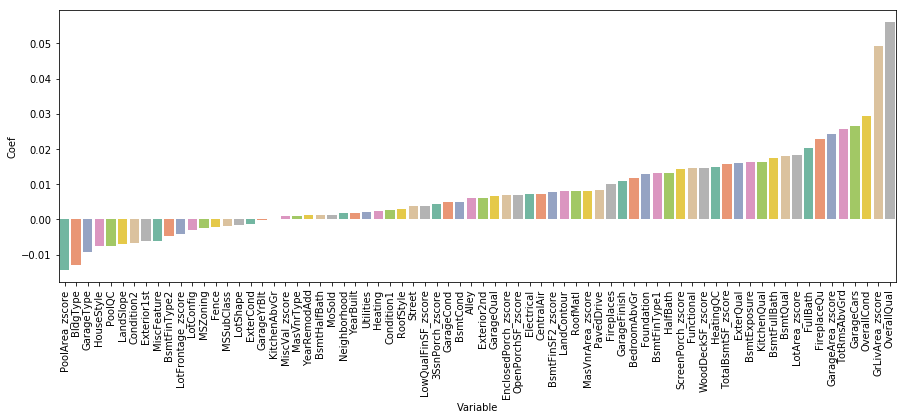

In [161]:
coeff = pd.DataFrame({"Coef":regr.coef_, "Variable":house_price_num_zv})
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
g = sn.barplot(y="Coef", x="Variable", data = coeff.sort_values(by="Coef"), palette="Set2")
plt.setp( g.get_xticklabels(), rotation=90)
plt.show()

In [162]:
metrics = get_regression_metrics(y_test,y_pred)

Mean squared error: 0.02
Root Mean squared error: 0.14
Explained Variance: 0.88
R2 Score: 0.88
Mean Absolute error: 0.10
Mean Squared Log error: 0.00
Median Absolute error: 0.07


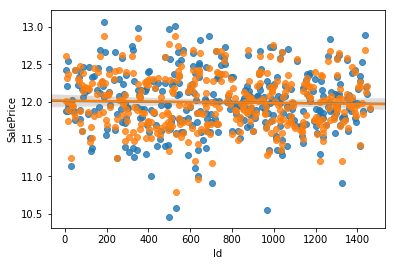

In [163]:
fig, ax = plt.subplots()
sn.regplot(X_test["Id"], y_test)
sn.regplot(X_test["Id"], y_pred)

In [164]:
train_error_df = get_metric_df(X_train["SalePrice"],y_train, y_train_pred)

In [165]:
train_error_df.head()

,ActualLogValue,ActualValue,ExpActualgLog,PredcitedValue,PredictedLogValue,Error,Error_per,Error_per_cls
177,12.058153,172500,172500.0,180222.867442,12.101950,-7722.867442,4.477025,1
311,11.790557,132000,132000.0,141773.096650,11.861983,-9773.096650,7.403861,1
31,11.914048,149350,149350.0,135233.549477,11.814759,14116.450523,9.451925,1
1097,12.043554,170000,170000.0,155964.339005,11.957383,14035.660995,8.256271,1
1420,12.100156,179900,179900.0,181139.644808,12.107024,-1239.644808,0.689074,1


In [166]:
test_error_df = get_metric_df(X_test["SalePrice"],y_test,y_pred)

In [167]:
test_error_df.head()

,ActualLogValue,ActualValue,ExpActualgLog,PredcitedValue,PredictedLogValue,Error,Error_per,Error_per_cls
539,12.513557,272000,272000.0,244245.634200,12.405930,27754.365800,10.203811,1
320,12.744444,342643,342643.0,300238.837639,12.612334,42404.162361,12.375610,1
164,11.931636,152000,152000.0,137024.688582,11.827916,14975.311418,9.852179,1
1249,11.686879,119000,119000.0,118651.468033,11.683946,348.531967,0.292884,1
985,11.736069,125000,125000.0,106146.823052,11.572579,18853.176948,15.082542,1


## Metrics

### Training Dataset

#### Metrics in Train Dataset

In [168]:
train_err_met = get_regression_metrics(train_error_df["ActualValue"], train_error_df["PredcitedValue"])

Mean squared error: 912163100.59
Root Mean squared error: 30202.04
Explained Variance: 0.82
R2 Score: 0.82
Mean Absolute error: 17419.34
Mean Squared Log error: 0.02
Median Absolute error: 11685.74


#### Plot of Actual Value and Predicted Value
Actual Value - Blue
Pred value - Orange

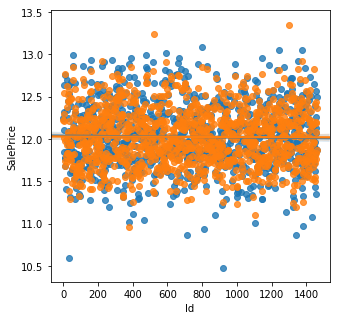

In [169]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sn.regplot(X_train["Id"], y_train)
sn.regplot(X_train["Id"], y_train_pred)

In most of the data points, the orange and blue dots overlap

#### Plot between actual and predicted values.

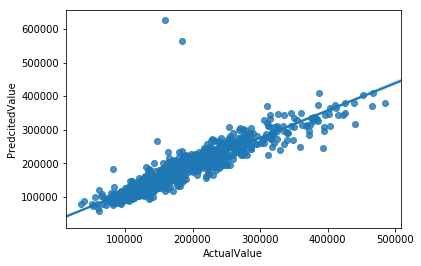

In [170]:
fig, ax = plt.subplots()
sn.regplot(train_error_df["ActualValue"], train_error_df["PredcitedValue"])

Most of the data points in training datset lie around the predictive line, although, few value are predicted too high. 

#### PLot beween Actual and Pred values colored by percentage error. 
 0,  16.66,  33.3,  50, 66.66,  83.33, 100

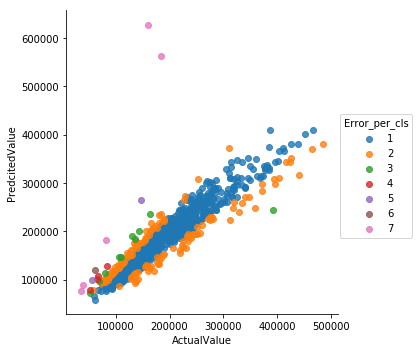

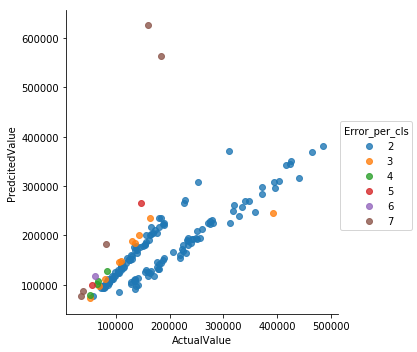

In [171]:
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False, data=train_error_df)
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False,  data=train_error_df.loc[
    train_error_df["Error_per_cls"]!=1])

#### Error Distributions

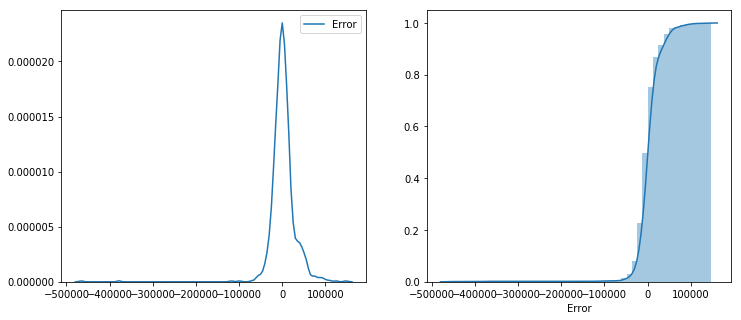

In [172]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.kdeplot(train_error_df["Error"],ax=ax[0])
sn.distplot(train_error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True), ax=ax[1])

Most of the errors are centered at 0

### Test Dataset

Metrics in Test Dataset

In [173]:
test_err_met = get_regression_metrics(test_error_df["ActualValue"], test_error_df["PredcitedValue"])

Mean squared error: 628269155.54
Root Mean squared error: 25065.30
Explained Variance: 0.88
R2 Score: 0.88
Mean Absolute error: 17145.62
Mean Squared Log error: 0.02
Median Absolute error: 11979.29


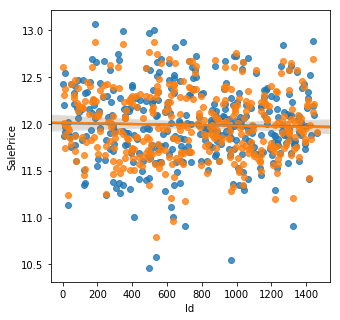

In [174]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sn.regplot(X_test["Id"], y_test)
sn.regplot(X_test["Id"], y_pred)

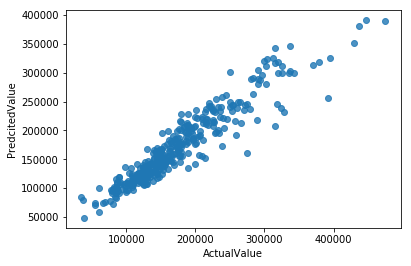

In [175]:
sn.regplot(test_error_df["ActualValue"], test_error_df["PredcitedValue"], fit_reg=False)

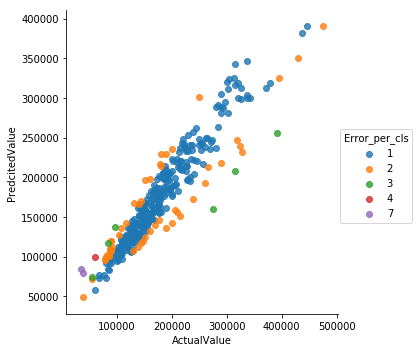

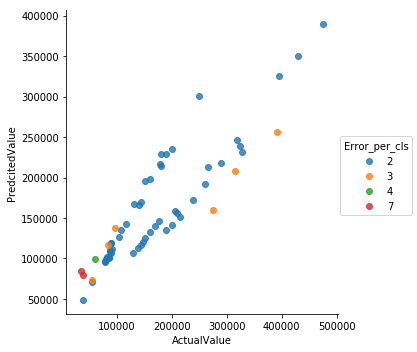

In [176]:
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False, data=test_error_df)
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False,  data=test_error_df.loc[
    test_error_df["Error_per_cls"]!=1])

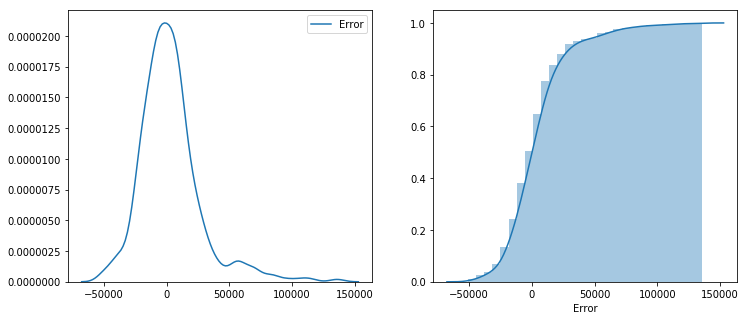

In [177]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.kdeplot(test_error_df["Error"],ax=ax[0])
sn.distplot(test_error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True), ax=ax[1])

In [178]:
set_all_error_metrics("Ridge_Regression",train_err_met,test_err_met,regr)

## Errors of all Models

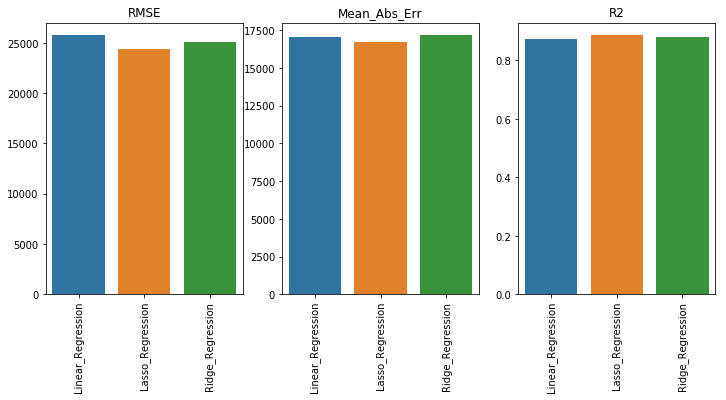

In [179]:
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(12,5)

x = []
y = []
for model_metric in all_error_metrics_dict_:
    x.append(all_error_metrics_dict_[model_metric]["Test"]["RMSE"])
    y.append(model_metric)
g = sn.barplot(y,x, ax=ax[0])
g.set_title("RMSE")
plt.setp(g.get_xticklabels(), rotation=90)

x = []
y = []
for model_metric in all_error_metrics_dict_:
    x.append(all_error_metrics_dict_[model_metric]["Test"]["Mean_Abs_Err"])
    y.append(model_metric)
g = sn.barplot(y,x, ax=ax[1])
g.set_title("Mean_Abs_Err")
plt.setp(g.get_xticklabels(), rotation=90)


x = []
y = []
for model_metric in all_error_metrics_dict_:
    x.append(all_error_metrics_dict_[model_metric]["Test"]["R2"])
    y.append(model_metric)
g = sn.barplot(y,x, ax=ax[2])
g.set_title("R2")
plt.setp(g.get_xticklabels(), rotation=90)

plt.show()

## Serializng Objects

In [180]:
# Serializing Missing Value Impute Dictionary
with open('SerializedObjects/missValDict.pkl','wb') as f:
    pickle.dump(all_imputed_vals_dict,f)

# Serializing Label Encoder Object
with open('SerializedObjects/labelEncDict.pkl','wb') as f:
    pickle.dump(house_prices_cat_dict,f)
    
# Serializing One Hot Encoder Object
with open('SerializedObjects/oneHotEncDict.pkl','wb') as f:
    pickle.dump(house_prices_cat_ohe_dict,f)

# Serializing Model Dict
with open('SerializedObjects/modelDict.pkl','wb') as f:
        pickle.dump(all_error_metrics_dict_,f)
        